In [76]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn import tree

In [77]:
# Reading the data
data = pd.read_csv('/content/titanic.csv')

In [78]:
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Only selecting important attributes.


In [79]:
data = data[['Survived','Pclass','Sex','Age',"Fare"]]

In [80]:
data.head(5)

,Survived,Pclass,Sex,Age,Fare
0,0,3,male,22.0,7.2500
1,1,1,female,38.0,71.2833
2,1,3,female,26.0,7.9250
3,1,1,female,35.0,53.1000
4,0,3,male,35.0,8.0500


Finding empty values in the attributes and filling them with the mean values as Decision Trees do not work well with empty values.


In [82]:
data.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
Fare          0
dtype: int64

In [83]:
data.groupby('Sex')['Age'].mean()

Sex
female    27.915709
male      30.726645
Name: Age, dtype: float64

In [84]:
data['Age'] = data.groupby('Sex')['Age'].transform(lambda x: x.fillna(x.mean()))

In [85]:
data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
Fare        0
dtype: int64

Changing Sex Data into binary values using Label Encoder.


In [86]:
labeler = LabelEncoder()

In [87]:
data['Sex'] = labeler.fit_transform(data.Sex)

In [88]:
data.tail(5)

,Survived,Pclass,Sex,Age,Fare
886,0,2,1,27.000000,13.00
887,1,1,0,19.000000,30.00
888,0,3,0,27.915709,23.45
889,1,1,1,26.000000,30.00
890,0,3,1,32.000000,7.75


In [89]:
X = data[['Age','Sex','Fare','Pclass']]
y = data['Survived']

Splitting Data into Train(80%) and Test(20%) Set.

In [90]:
X_train, X_test , y_train, y_test = train_test_split(X, y , test_size=0.2,random_state=80)

Using Entropy as a measure to split at attributes.


In [92]:
dtree = DecisionTreeClassifier(random_state=2,criterion='entropy')
dtree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=2)

In [93]:
treetrainPredictions = dtree.predict(X_train)
treetestPredictions = dtree.predict(X_test)

In [94]:
accuracy_score(y_train,treetrainPredictions)

0.9803370786516854

It is obvious that the Decision Tree is overfiting based on the Train and Test accuracy scores. The Tree is learning the training data a little too well.

In [95]:
accuracy_score(y_test,treetestPredictions)

0.7932960893854749

Visualizing the tree.

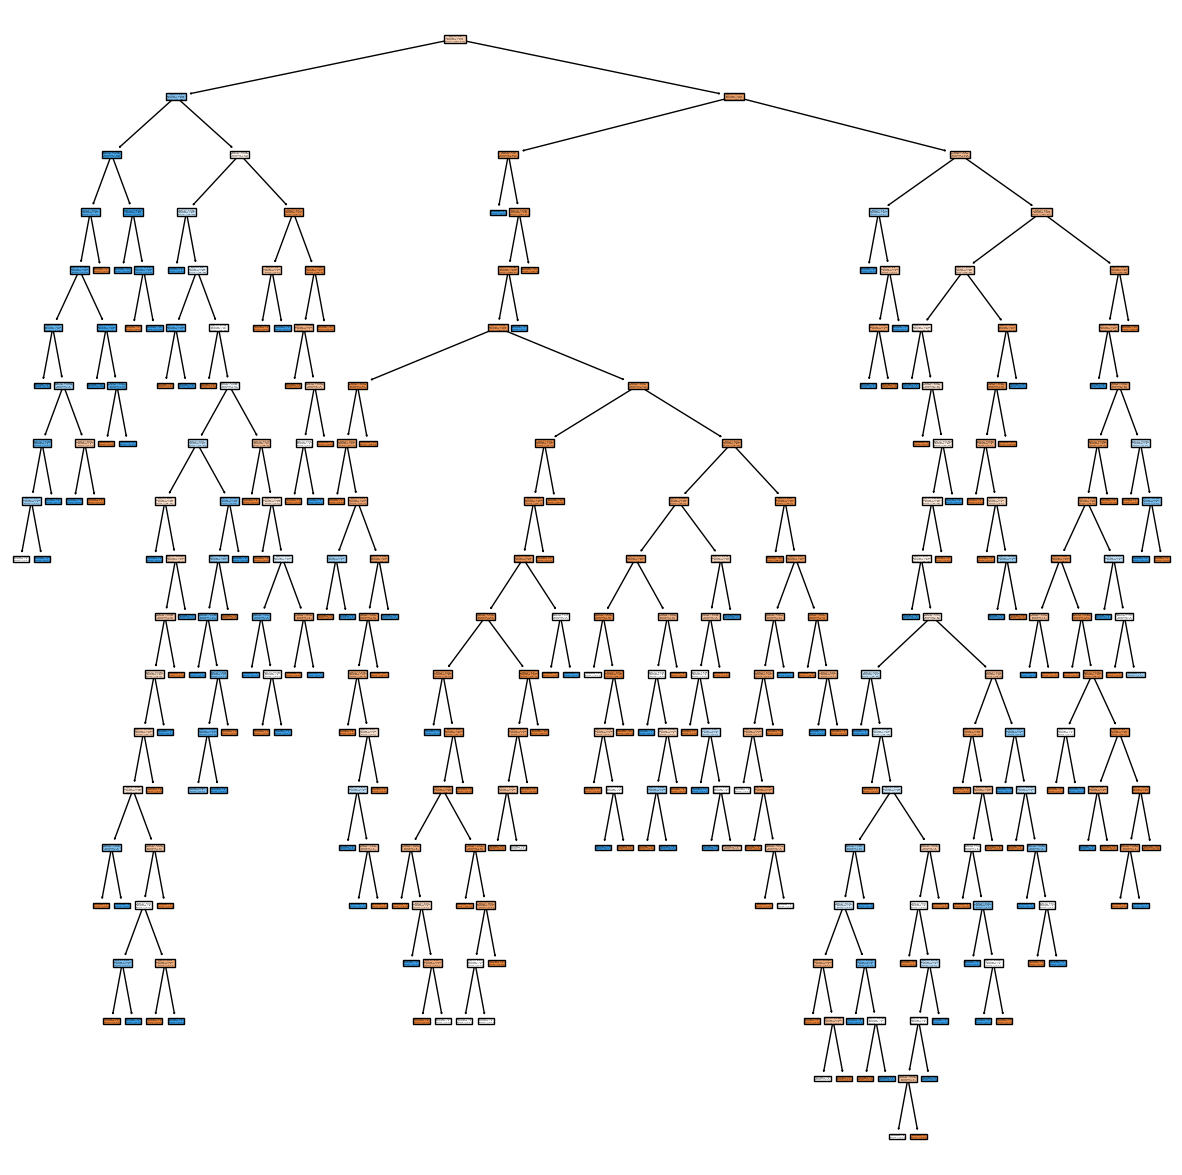

In [96]:
plt.figure(figsize=(15,15))
tree.plot_tree(dtree,filled=True)
plt.show()

In [98]:
print(classification_report(y_test,treetestPredictions))


              precision    recall  f1-score   support

           0       0.83      0.82      0.83       107
           1       0.74      0.75      0.74        72

    accuracy                           0.79       179
   macro avg       0.78      0.79      0.79       179
weighted avg       0.79      0.79      0.79       179



Confusion Matrix for test results.


<Axes: >

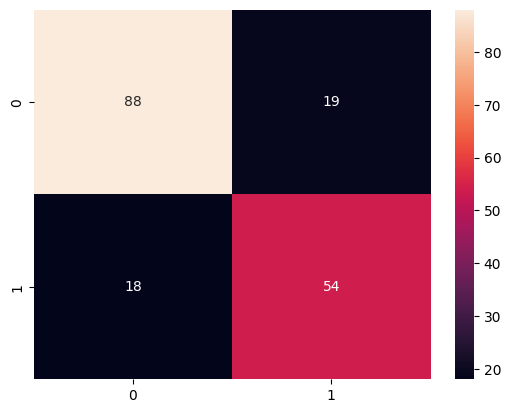

In [99]:
confusion = confusion_matrix(y_test,treetestPredictions)
sns.heatmap(confusion,annot=True)

Pruning the Decision Tree with Alpha and Impurity Values.

In [101]:
prunePath = dtree.cost_complexity_pruning_path(X_train,y_train)
alpha, impurity = prunePath.ccp_alphas, prunePath.impurities
#print(alpha,impurity)

Text(0.5, 1.0, 'Impurity vs alpha for training set')

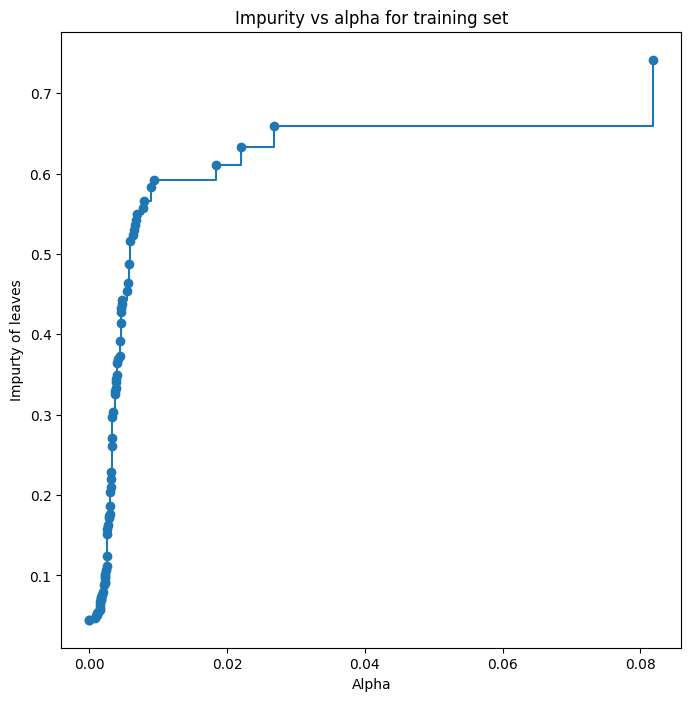

In [102]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(alpha[:-1],impurity[:-1],marker="o",drawstyle="steps-post")
ax.set_xlabel("Alpha")
ax.set_ylabel("Impurty of leaves")
ax.set_title('Impurity vs alpha for training set')

In [103]:
trees = []
for al in alpha:
  atree = DecisionTreeClassifier(random_state=2,ccp_alpha=al)
  atree.fit(X_train,y_train)
  trees.append(atree)

print("Number of nodes in the final tree is {} with alpha={}".format(trees[-1].tree_.node_count,alpha[-1]))

Number of nodes in the final tree is 1 with alpha=0.2157175790499377


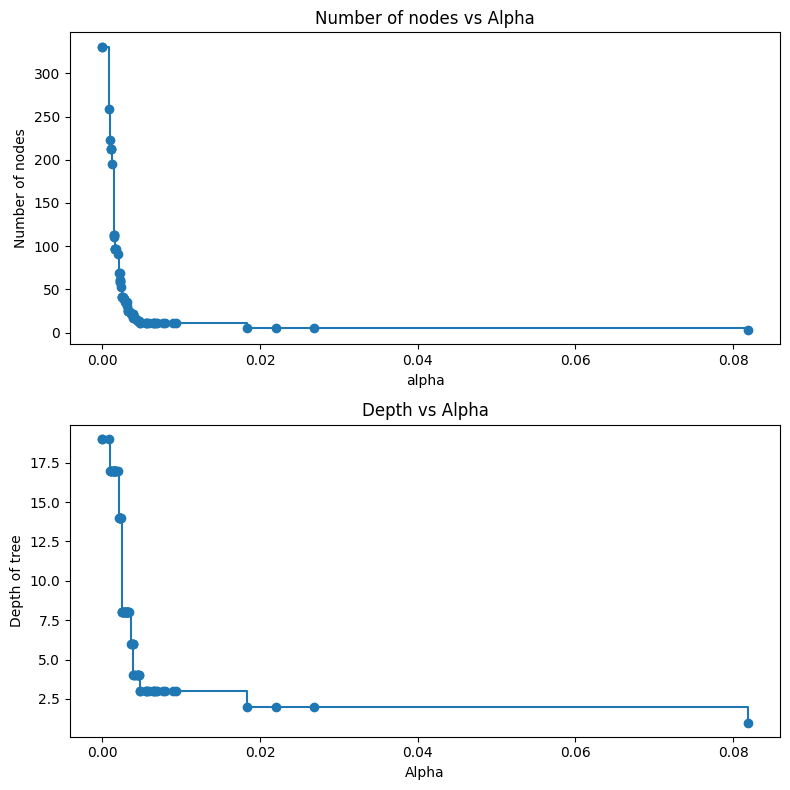

In [104]:
trees = trees[:-1]
alpha = alpha[:-1]

nodes = [dtree.tree_.node_count for dtree in trees]
depth = [dtree.tree_.max_depth for dtree in trees]

fig , ax = plt.subplots(2,1, figsize=(8,8))
ax[0].plot(alpha, nodes, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("Number of nodes")
ax[0].set_title("Number of nodes vs Alpha")
ax[1].plot(alpha, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("Alpha")
ax[1].set_ylabel("Depth of tree")
ax[1].set_title("Depth vs Alpha")
fig.tight_layout()

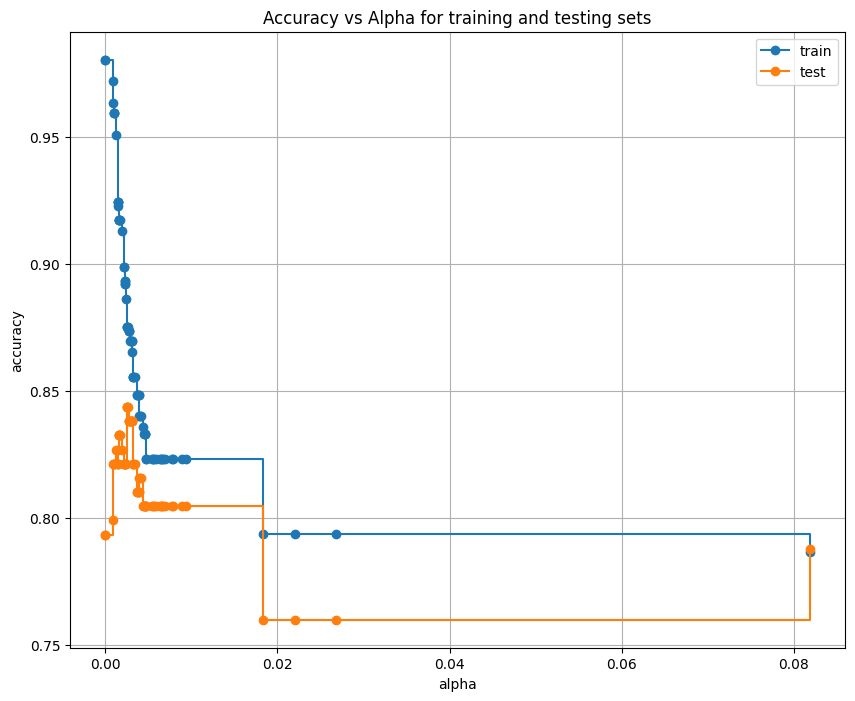

In [105]:
trainScores = [tree.score(X_train,y_train) for tree in trees]
testScores = [tree.score(X_test,y_test) for tree in trees]
fig, ax = plt.subplots(figsize=(10,8))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs Alpha for training and testing sets")
ax.plot(alpha, trainScores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(alpha, testScores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.grid()
plt.show()

Pick alpha = 0.3 after analysing the graph.

In [106]:
dtree = DecisionTreeClassifier(random_state=2,ccp_alpha=0.003)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.003, random_state=2)

In [107]:
testPrediction = dtree.predict(X_test)

Accuracy for the test set increases.

In [108]:
accuracy_score(testPrediction,y_test)

0.8379888268156425

Visualizing the final tree.

[Text(0.5, 0.9444444444444444, 'x[1] <= 0.5\ngini = 0.471\nsamples = 712\nvalue = [442, 270]'),
 Text(0.29411764705882354, 0.8333333333333334, 'x[3] <= 2.5\ngini = 0.39\nsamples = 252\nvalue = [67, 185]'),
 Text(0.23529411764705882, 0.7222222222222222, 'gini = 0.085\nsamples = 135\nvalue = [6, 129]'),
 Text(0.35294117647058826, 0.7222222222222222, 'x[2] <= 23.35\ngini = 0.499\nsamples = 117\nvalue = [61, 56]'),
 Text(0.29411764705882354, 0.6111111111111112, 'x[0] <= 27.958\ngini = 0.487\nsamples = 93\nvalue = [39, 54]'),
 Text(0.23529411764705882, 0.5, 'x[2] <= 7.902\ngini = 0.456\nsamples = 74\nvalue = [26, 48]'),
 Text(0.17647058823529413, 0.3888888888888889, 'gini = 0.32\nsamples = 30\nvalue = [6, 24]'),
 Text(0.29411764705882354, 0.3888888888888889, 'x[2] <= 15.373\ngini = 0.496\nsamples = 44\nvalue = [20, 24]'),
 Text(0.17647058823529413, 0.2777777777777778, 'x[2] <= 13.935\ngini = 0.473\nsamples = 26\nvalue = [16, 10]'),
 Text(0.11764705882352941, 0.16666666666666666, 'x[2] <= 10

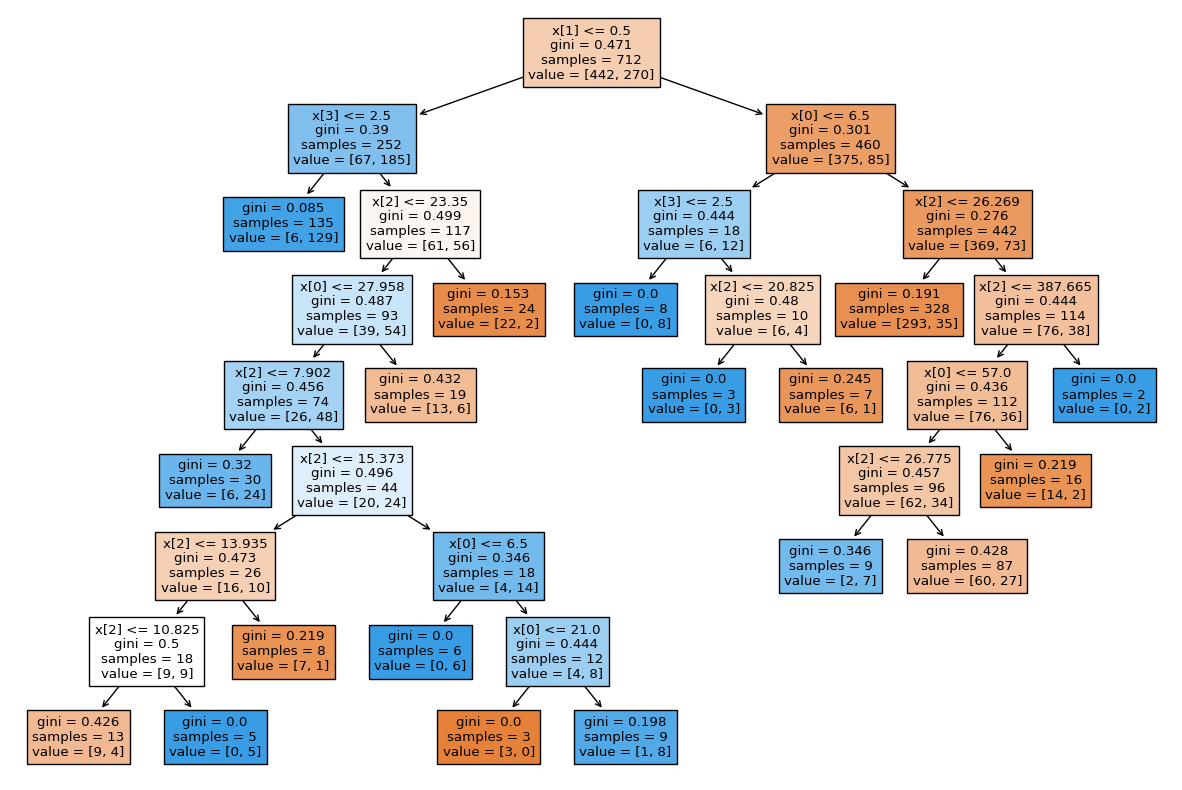

In [109]:
plt.figure(figsize=(15,10))
tree.plot_tree(dtree,filled=True)